In [1]:
import galsim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload

%autoreload 2

%matplotlib notebook
sns.set()

In [17]:
dim = 128
im_cen = (dim - 1)/2
dx_g = 10 * 0.25
dy_g = 6 * 0.25
g = galsim.Gaussian(fwhm=0.9)
gg = galsim.Gaussian(fwhm=2)
psf = galsim.Gaussian(fwhm=0.9).shear(g1=-0.4, g2=0.8)

# make image by shearing everything w/ shifts
ims = galsim.Convolve(
    galsim.Sum([
        g.shift(dx=dx_g, dy=dy_g),
        gg.shift(dx=-dx_g, dy=-dy_g)]).shear(g1=0.1, g2=0),
    psf).drawImage(nx=dim, ny=dim, scale=0.25).array

# make image by shearing inplace and computing new pos
sm = galsim.Shear(g1=0.1, g2=0).getMatrix()
sdx_g, sdy_g = np.dot(sm, np.array([dx_g, dy_g]))

im = np.zeros((dim, dim), dtype='f8')

band_objects = [
    galsim.Convolve(g.shift(dx=dx_g, dy=dy_g).shear(g1=0.1, g2=0).shift(dx=-sdx_g, dy=-sdy_g), psf),
    galsim.Convolve(gg.shift(dx=-dx_g, dy=-dy_g).shear(g1=0.1, g2=0).shift(dx=sdx_g, dy=sdy_g), psf)]
positions = [
    galsim.PositionD(x=sdx_g/0.25 + im_cen, y=sdy_g/0.25 + im_cen),
    galsim.PositionD(x=-sdx_g/0.25 + im_cen, y=-sdy_g/0.25 + im_cen)]
for obj, pos in zip(band_objects, positions):
    # draw with setup_only to get the image size
    _im = obj.drawImage(
        scale=0.25,
        setup_only=True).array
    assert _im.shape[0] == _im.shape[1]

    # now get location of the stamp
    x_ll = int(pos.x - (_im.shape[0] - 1)/2)
    y_ll = int(pos.y - (_im.shape[0] - 1)/2)
    dx = pos.x - (x_ll + (_im.shape[0] - 1)/2)
    dy = pos.y - (y_ll + (_im.shape[0] - 1)/2)
    dx *= 0.25
    dy *= 0.25
    stamp = obj.shift(dx=dx, dy=dy).drawImage(
        nx=_im.shape[1],
        ny=_im.shape[0],
        scale=0.25)

    im[y_ll:y_ll+stamp.array.shape[0],
       x_ll:x_ll+stamp.array.shape[1]] += stamp.array

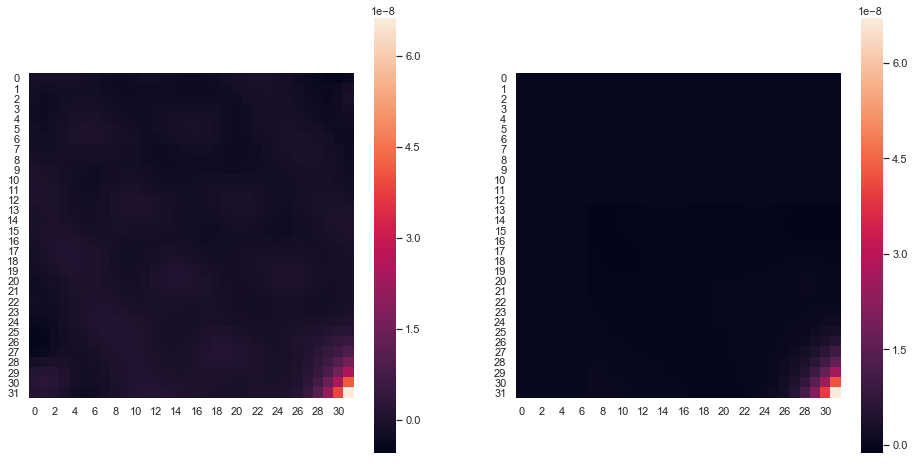

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(ims[0:32, 0:32], square=True, ax=axs[0])
sns.heatmap(im[0:32, 0:32], square=True, ax=axs[1])

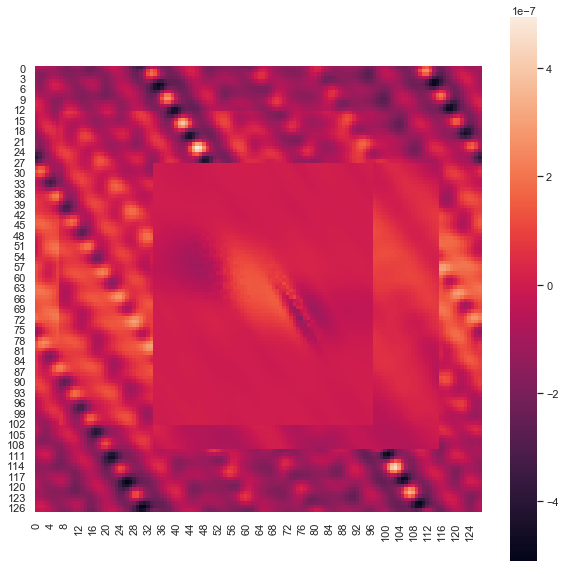

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap((ims - im)/np.max(ims), square=True)

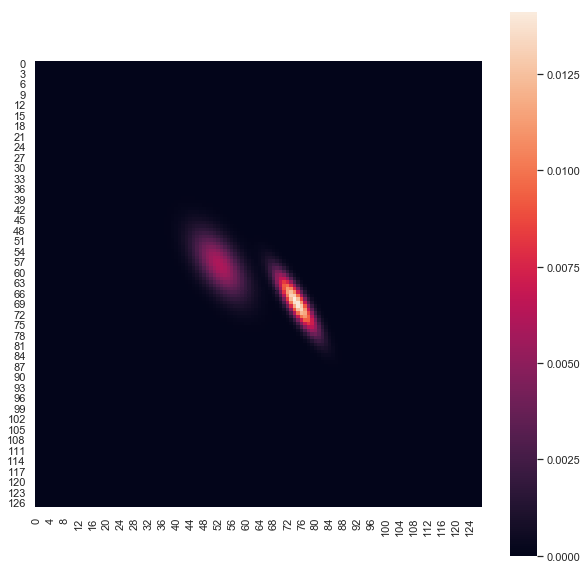

In [20]:
plt.figure(figsize=(10, 10))
sns.heatmap(im, square=True)